In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

원본이미지 크기 m x n 
 필터(filter, kernel) 크기 n*n
  필터가 
5. 패딩 (Padding)
 - Feature map 의 크기가 줄어들지 않도록 입력 데이터의  외곽에 지정된 픽셀만큼 특정값으로 채워 넣는것
 - 보통은 0으로 채움
 - 다음의 크기 만큼 상하 좌우에 padding(K:필터 크기)
 6. 채널(Channel)
 - 1 whdfbdml epdlxj
 - 컬러 사진은 RGB 3개 성분의 3종의 이미지 -> 3채널
   - 높이 39픽셀, 폭 31픽셀인 컬러사진(39,31,3)
 - 흑밸 사진 -> 1채널
   - 높이 39 픽셀, 폭 31 픽셀인 흑백 사진 -> (39, 31, 1)
 7 활성화 및 활성화 맵 (Activation map)
  - 활성화: 
   - feature map의 값에 환성화 함수를 적용하는 것
  - 활성화 함수:
   - reLU(rectified Linear Unit) 함수
  - 활성화 맵
   - Feature map을 활성화 한 결과인 2차원 맵 
8 풀링(pooing)
- 합성곱(convolution)의 결과의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용
- 종류
  - 최대 풀링
  - 평균 풀링
  - 확률적 풀링
- Pooling size는 정사각형
- 입력데이터의 크기는
- 

9 Fully connected neural network
= Flatten layer + Softmax layer
 - 마지막 풀링이 끝난 후 NxN 크기의 2D 결과를 1차원 벡터로 표현(flatten layer)후, 다층 신경망(softmax layer)을 구성
 - 다층 퍼셉트론: 오류역전파 학습(경사 하강법)


 Training Covolution Neural Networks
  - Back propagation + stchastic gradient 

  CNN중 레쓰네 가 전이 학습

# 1. CNN을 활용한 MNIST 손글씨 인식

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# data 불러오기
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('학습셋 이미지: %d 개' % (X_train.shape[0]))
print('테스트셋 이미지: %d 개' % (X_test.shape[0]))

11490434/11490434 [==============================] - 0s 0us/step
학습셋 이미지: 60000 개
테스트셋 이미지: 10000 개


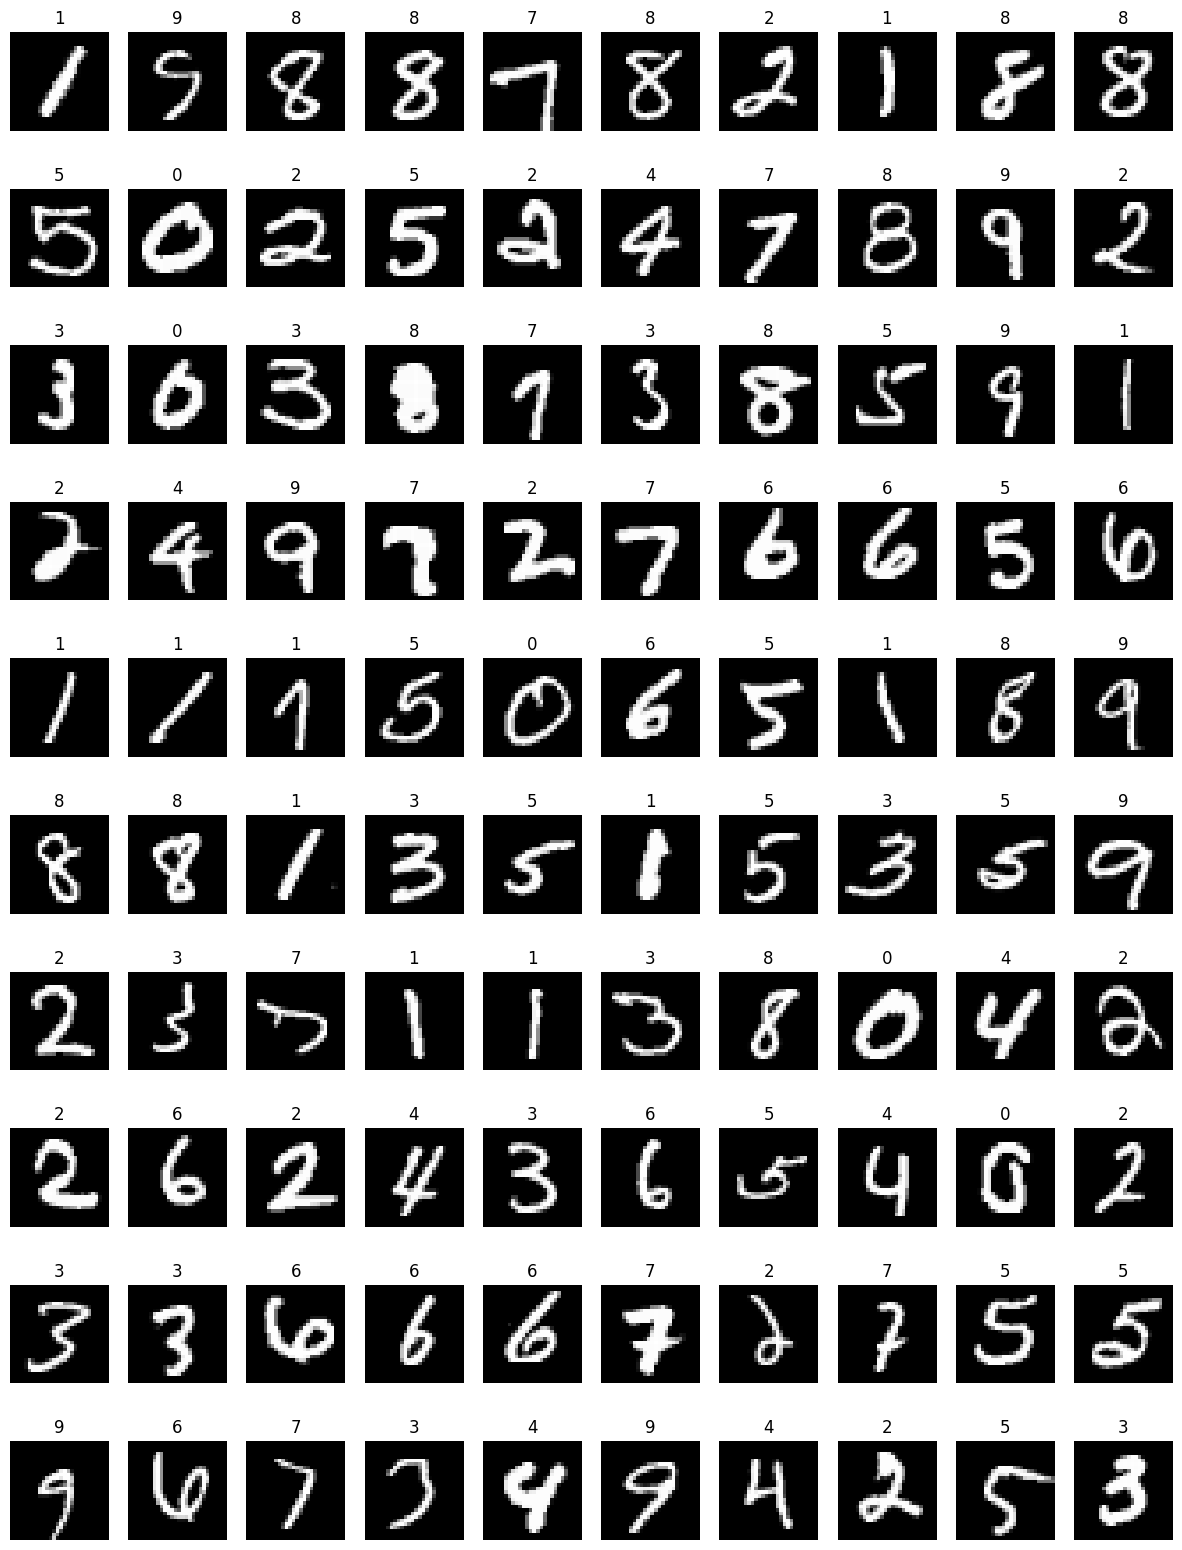

In [4]:
# 숫자 출력
import random
n_samples=100
indices = random.sample(range(X_train.shape[0]), n_samples)

plt.figure(figsize=(15, 20))
for i, idx in enumerate(indices):
    plt.subplot(10,10, i+1)
    plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    plt.title(Y_train[idx])
    plt.axis('off')
plt.show()

## 데이터 전처리

In [5]:
# 2차원 영상, 1 channel
X_train = X_train.reshape(X_train.shape[0],28,28,1)  # X_train.shape[0] : number of samples

# 0~255 값을 0~1 사이 값으로 Min_Max 정규화
X_train = X_train / 255.

# 테스트셋 변환
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)/255.

Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

print(X_train[0].shape)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(28, 28, 1)
(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 1) (10000, 1)


In [6]:
np.max(X_train)

1.0

In [7]:
from google.colab import drive
drive.mount('/content/drive')
MODEL_DIR = '/content/drive/MyDrive/ICTIS_2023/data/'

Mounted at /content/drive


In [11]:
model = Sequential()

model.add( Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'))
model.add( MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])


In [13]:
# 모델 저장 조건 설정
modelfile = MODEL_DIR+ 'MnistCNN_best.h5'  
checkpointer = ModelCheckpoint(filepath=modelfile, 
                               monitor='val_loss', verbose=1, 
                               save_best_only=True)

# 학습의 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=10)

fit_history = model.fit(X_train, Y_train, 
                          validation_data=(X_test, Y_test),
                          epochs=50,
                          batch_size=200,
                          verbose=0,
                          callbacks=[early_stopping_callback, checkpointer])

print("Train Accuracy:", model.evaluate(X_train, Y_train)[1])
print("Test Accuracy:",  model.evaluate(X_test, Y_test)[1])

KeyboardInterrupt: ignored

In [ ]:
#학습 이력 확인하기
vloss = fit_history.history['val_loss'] # 테스트셋 loss
loss = fit_history.history['loss'] # 학습셋  

plt.figure(figsize=(12,5))
epoch = np.arange(len(loss))
plt.plot(epoch, vloss, c='r', marker='.', label='validation_loss')
plt.plot(epoch, loss, c='b',  marker='.',label='loss')
plt.legend(loc='best')

vacc = fit_history.history['val_accuracy'] # 테스트셋 
acc = fit_history.history['accuracy'] # 학습셋 정확도

plt.figure(figsize=(12,5))
epoch = np.arange(len(acc))
plt.plot(epoch, vacc, 'r', marker='.', label='validation_acc')
plt.plot(epoch, acc, 'b',  marker='.', label='accuracy')
plt.legend(loc='best')
plt.show()

## ◆ CNN 모델 분석

In [ ]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = x_test.reshape(-1,  )/255.
print(x.shape, x.min(), x.max())

from tensorflow.keras.models import load_model
modelfile = MODEL_DIR + 'MnistCNN_best.h5'
model = load_model(modelfile)

In [ ]:
model.summary()

In [ ]:
model.layers

In [ ]:
conv1 = keras.Model(inputs= model.input, outputs= model.layers[0].output)
conv2 = keras.Model(inputs= model.input, outputs= model.layers[2].output)
pool1 = keras.Model(inputs= model.input, outputs= model.layers[1].output)
pool2 = keras.Model(inputs= model.input, outputs= model.layers[3].output)


## - Kernel 확인

In [ ]:
conv = model.layers

print(conv.weights[0].shape, conv.weights[1].shape)

In [ ]:
conv.weights

In [ ]:
conv_weights = conv.weights[0].numpy()

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 8, figsize=(10,6))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(conv_weights[:,:,  , i*8 + j], 
                          cmap='gray')
        axs[i, j].axis('off')

plt.show()

## - Feature map 확인

In [ ]:
samples = [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
inputs = x[samples]
print(inputs.shape)
y_true = y_test[samples]
print(y_true)

In [ ]:
feature_maps_1 = conv1.predict(inputs)
type(feature_maps_1), feature_maps_1.shape

In [ ]:
pool_maps_1 = pool1.predict(inputs)
type(pool_maps_1), pool_maps_1.shape

In [ ]:
feature_maps_2 = conv2.predict(inputs)
type(feature_maps_2), feature_maps_2.shape

In [ ]:
pool_maps_2 = pool2.predict(inputs)
type(pool_maps_2), pool_maps_2.shape

In [ ]:
def feature_map_1(k):
    fig, axs = plt.subplots(4, 8, figsize=(10,5))
    for j  in range(4):
        for i in range(8):
            axs[j, i].imshow(feature_maps_1[k,:,:,i+j*8], cmap='gray')
            axs[j, i].axis('off')
            axs[j, i].grid(False)

    plt.show()

In [ ]:
def pooling_layer_1(k):
    fig, axs = plt.subplots(4, 8, figsize=(5,3))
    for j  in range(4):
        for i in range(8):
            axs[j, i].imshow(pool_maps_1[k,:,:,i+j*8], cmap='gray')
            axs[j, i].axis('off')
            axs[j, i].grid(False)

    plt.show() 

In [ ]:
def feature_map_2(k):
    fig, axs = plt.subplots(8, 8, figsize=(5,5))
    for j  in range(8):
        for i in range(8):
            axs[j, i].imshow(feature_maps_2[k,:,:,i+j*8], cmap='gray')
            axs[j, i].axis('off')
            axs[j, i].grid(False)

    plt.show()

In [ ]:
def pooling_layer_2(k):
    fig, axs = plt.subplots(8, 8, figsize=(3,3))
    for j  in range(8):
        for i in range(8):
            axs[j, i].imshow(pool_maps_2[k,:,:,i+j*8], cmap='gray')
            axs[j, i].axis('off')
            axs[j, i].grid(False)

    plt.show()

In [ ]:
def disp_featuremaps(k):  # 0 ~ 9
    feature_map_1(k)
    pooling_layer_1(k)
    feature_map_2(k)
    pooling_layer_2(k)

In [ ]:
disp_featuremaps(k=0)

# 2. 이미지 OCR- 연속 문자 인식 프로젝트

- imutils 설치 후 kernel 재부팅하지 않고 아래 코드 바로실행 가능

In [ ]:
import cv2

IMG_DIR="/content/drive/MyDrive/ICTIS_2023/img/ocr/"

## (1) 이미지에서 글자가 있는 영역 추출

In [ ]:
# 이미지 읽어 들이기 
im = cv2.imread(IMG_DIR+'numbers.png')

# 그레이스케일로 변환하고 블러링 후 이진화
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

# 윤곽 추출 
contours, _ = cv2.findContours(thresh, 
                            cv2.RETR_ , 
                            cv2.CHAIN_APPROX_SIMPLE)

# 추출한 윤곽을 bounding box 처리
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt) 
    if h < 20: continue # 너무 작으면 건너뛰기
    red = (0, 0, 255)
    cv2.rectangle(im, (x, y), (x+w, y+h), red, 2)
    
cv2.imwrite(IMG_DIR+'numbers-cnt.png', im)

- https://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=find%20contours#cv2.findContours

In [ ]:
plt.figure(figsize=(5,4))
plt.imshow(im)
plt.grid(False)
plt.show()

## (2) 개별 숫자 영역 추출하여 영상 리스트 만들기

In [ ]:
# 추출한 좌표 정렬하기 
rects = []
im_w = im.shape[1]
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    if w < 10 or h < 10: continue # 너무 작으면 생략하기
    if w > im_w / 5: continue # 너무 크면 생략하기
    y2 = round(y / 10) * 10 # Y좌표 맞추기
    index = y2 * im_w  + x
    rects.append((index, x, y, w, h))
rects = sorted(rects, key=lambda x: ) # 정렬하기
print(rects[:5])

In [ ]:
# 해당 영역의 이미지 데이터 추출하기 
X = []
for i, r in enumerate(rects):
    index, x, y, w, h = r
    num = gray[y:y+h, x:x+w] # 부분 이미지 추출하기
    # 반전하기
    # 정사각형 내부에 그림 옮기기
    ww = round((w if w > h else h) * 1.85) 
    spc = np.zeros((ww, ww))
    wy = (ww-h)//2
    wx = (ww-w)//2
    spc[wy:wy+h, wx:wx+w] = num
    num = cv2.resize(spc, (28, 28)) # MNIST 크기 맞추기
    X.append(num)
print(len(X))

In [ ]:
X = np.array(X)
X.shape

##  (3) MLP 모델로 인식하기

In [ ]:
X_test = X.copy()

In [ ]:
X_test = X_test 
X_test.min(), X_test.max(), X_test.shape

In [ ]:
from tensorflow.keras.models import load_model
modelfile = MODEL_DIR+"MnistMLP_best.h5"
model = load_model(modelfile)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True)

In [ ]:
# 예측하기 
s = "31415926535897932384" + \
    "62643383279502884197" + \
    "16939937510582097494" + \
    "45923078164062862089" + \
    "98628034825342117067"
answer = list(s)

ng_list=[]
ok = 0
nlist = model.predict(X_test)
for i, n in enumerate(nlist):
    ans = n
    if ans == int(answer[i]):
        ok += 1
    else:
        print("[ng]", i, "번째", ans, "!=", answer[i], np.int32(n*100))
        ng_list.append(i)
print('오답 수:', len(ng_list),'\n 정답률:', ok / len(nlist))

In [ ]:
# 오답 출력
plt.figure(figsize=(8, 2))
for i, idx in enumerate(ng_list):
    plt.subplot(2,8, i+1)
    plt.imshow( , cmap='gray')
plt.show()

## (4) CNN 모델로 인식하기

In [ ]:
X_test = X
X_test.shape

In [ ]:
from tensorflow.keras.models import load_model
modelfile =MODEL_DIR+'MnistCNN_best.h5'
model = load_model(modelfile)

plot_model(model, show_shapes=True)

In [ ]:
# 예측하기 
s = "31415926535897932384" + \
    "62643383279502884197" + \
    "16939937510582097494" + \
    "45923078164062862089" + \
    "98628034825342117067"
answer = list(s)

type
ng_list=[]
ok = 0
nlist = model.predict(X_test)
for i, n in enumerate(nlist):
    ans = n
    if ans == int(answer[i]):
        ok += 1
    else:
        print("[ng]", i, "번째", ans, "!=", answer[i], np.int32(n*100))
        ng_list.append(i)
print("정답률:", ok / len(nlist))

#  3. OpenCV로 얼굴 인식하기

In [ ]:
import matplotlib.pyplot as plt
import cv2

IMG_DIR = "/content/drive/MyDrive/ICTIS_2023/img/face/"

## (1) 사진에서 얼굴부분 찾기

- https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html

In [ ]:
def face_detection(IMG_DIR, image_file, rst_file, min_size=(150,150)):
    # 이미지 읽어 들이기 
    image = cv2.imread(image_file)

    # 그레이스케일로 변환하기
    image_gs = cv2.cvtColor(image, cv2.COLOR_ )

    # 캐스케이드 파일의 경로 지정하기 
    cascade_file = IMG_DIR+"haarcascade_frontalface_alt.xml"

    # 얼굴 인식 특징 파일 읽어 들이기 
    cascade = cv2.CascadeClassifier(cascade_file)

    # 얼굴 인식 실행하기
    face_list = cascade.detectMultiScale(image_gs,
        scaleFactor=1.1,
        minNeighbors=1,
        minSize=min_size)
    
    if len(face_list) > 0:
        # 인식한 부분 표시하기 
        color = (0, 0, 255)  # Red
        for face in face_list:
            x,y,w,h = face
            cv2.rectangle(image, (x,y), (x+w, y+h), color, thickness=8)
        # 파일로 출력하기 
        cv2.imwrite(rst_file, image)
        return face_list
    else:
        return None

In [ ]:
def displayResult(image_file, rst_file):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    im = plt.imread(image_file)
    plt.xlabel('Original')
    plt.imshow(im)
    
    plt.subplot(1,2,2)
    im = plt.imread(rst_file)
    plt.xlabel('Result')
    plt.imshow(im)
    plt.show()

In [ ]:
image_file =IMG_DIR+ "Lena.jpg"
rst_file= IMG_DIR+"Lena_facedetect-output.png"

face_list = face_detection(IMG_DIR, image_file, rst_file)
print(face_list)
displayResult(image_file, rst_file)

In [ ]:
image_file =IMG_DIR+ "people.png"
rst_file= IMG_DIR+"people_facedetect-output.png"

face_list = face_detection(IMG_DIR, image_file, rst_file, (100,100))
print(face_list)
displayResult(image_file, rst_file)

##  (2) 얼굴 비식별화: 모자이크 방식 & Blurring

###  ㉠ 모자이크 방식

In [ ]:
def make_mosaic(image_file, rst_file, face_list, mosaic_rate=10 ):
    image = cv2.imread(image_file)

    color = (0, 0, 255)
    for (x,y,w,h) in face_list:
        # 얼굴 부분 자르기 
        face_img = image[y:y+h, x:x+w]
        # 자른 이미지를 지정한 배율로 확대/축소
        face_img = cv2. (face_img, (w//mosaic_rate, h//mosaic_rate))
        # 확대/축소한 그림을 원래 크기로
        face_img = cv2. (face_img, (w, h), 
            interpolation=cv2.INTER_AREA)
        # 원래 이미지에 붙이기 
        image[y:y+h, x:x+w] = face_img
    # 렌더링 결과를 파일에 출력
    cv2.imwrite(rst_file, image)

In [ ]:
image_file =IMG_DIR+ "Lena.jpg"
rst_file= IMG_DIR+"Lena-mosaic.jpg"

face_list= face_detection(IMG_DIR, image_file, rst_file, (70,70))
print(face_list)
make_mosaic(image_file, rst_file, face_list, mosaic_rate=10 )
displayResult(image_file, rst_file)

###  ㉡ Blurring 방식

In [ ]:
def make_blur(image_file, rst_file, face_list, ksize=23, sigma_X=30):
    image = cv2.imread(image_file)

    color = (0, 0, 255)
    for (x,y,w,h) in face_list:
        # 얼굴 부분 자르기 
        face_img = image[y:y+h, x:x+w]
        # 블러링
        face_img = cv2.GaussianBlur(face_img, (ksize, ksize), sigma_X)
        # 원래 이미지에 붙이기 
        image[y:y+h, x:x+w] = face_img
    # 렌더링 결과를 파일에 출력
    cv2.imwrite(rst_file, image)

In [ ]:
image_file =IMG_DIR+ "Lena.jpg"
rst_file= IMG_DIR+"Lena-mosaic.jpg"
face_list= face_detection(IMG_DIR, image_file, rst_file, (70,70))
print(face_list)
make_blur(image_file, rst_file, face_list, sigma_X=30 )
displayResult(image_file, rst_file)